In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
import re
import string
import joblib
from google.colab import files
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

In [2]:
# Download NLTK stopwords
nltk.download('stopwords')
print("\nStopwords in English:", stopwords.words('english'))


Stopwords in English: ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same',

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
# Upload the datasets
print("Please upload True.csv and Fake.csv")
uploaded = files.upload()

Please upload True.csv and Fake.csv


Saving Fake.csv to Fake.csv
Saving True.csv to True.csv


In [4]:
# Importing Dataset
df_fake = pd.read_csv('Fake.csv')
df_true = pd.read_csv('True.csv')

In [5]:
# Inserting a column "class" as target feature
df_fake["class"] = 0
df_true["class"] = 1

In [6]:
# Check shapes
print("Fake dataset shape:", df_fake.shape)
print("True dataset shape:", df_true.shape)

Fake dataset shape: (23481, 5)
True dataset shape: (21417, 5)


In [7]:
# Removing last 10 rows for manual testing
df_fake_manual_testing = df_fake.tail(10)
for i in range(len(df_fake)-1, len(df_fake)-11, -1):
    df_fake.drop([i], axis=0, inplace=True)

In [8]:
df_true_manual_testing = df_true.tail(10)
for i in range(len(df_true)-1, len(df_true)-11, -1):
    df_true.drop([i], axis=0, inplace=True)

In [9]:
# Add class to manual testing data
df_fake_manual_testing["class"] = 0
df_true_manual_testing["class"] = 1

/tmp/ipython-input-1810459385.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fake_manual_testing["class"] = 0
/tmp/ipython-input-1810459385.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_true_manual_testing["class"] = 1


In [10]:
# Save manual testing data
df_manual_testing = pd.concat([df_fake_manual_testing, df_true_manual_testing], axis=0)
df_manual_testing.to_csv("manual_testing.csv")

In [11]:
# Merging True and Fake Dataframes
df_merge = pd.concat([df_fake, df_true], axis=0)

In [12]:
# Create new features
df_merge['TextLength'] = df_merge['text'].apply(lambda x: len(str(x).split()))
df_merge['TitleLength'] = df_merge['title'].apply(lambda x: len(str(x).split()))

In [13]:
# Handle missing values
df_merge['text'] = df_merge['text'].fillna('')
df_merge['title'] = df_merge['title'].fillna('')
df_merge['subject'] = df_merge['subject'].fillna(df_merge['subject'].mode()[0])

In [14]:
# Combine title and text into 'content'
df_merge['content'] = df_merge['title'] + ' ' + df_merge['text']

In [15]:
# Display dataset info
print("\nMerged Dataset Info:")
df_merge.info()


Merged Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 44878 entries, 0 to 21406
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        44878 non-null  object
 1   text         44878 non-null  object
 2   subject      44878 non-null  object
 3   date         44878 non-null  object
 4   class        44878 non-null  int64 
 5   TextLength   44878 non-null  int64 
 6   TitleLength  44878 non-null  int64 
 7   content      44878 non-null  object
dtypes: int64(3), object(5)
memory usage: 3.1+ MB


In [16]:
# Display missing values
print("\nMissing Values:")
print(df_merge.isnull().sum())


Missing Values:
title          0
text           0
subject        0
date           0
class          0
TextLength     0
TitleLength    0
content        0
dtype: int64



Visualizing Subject vs Class:


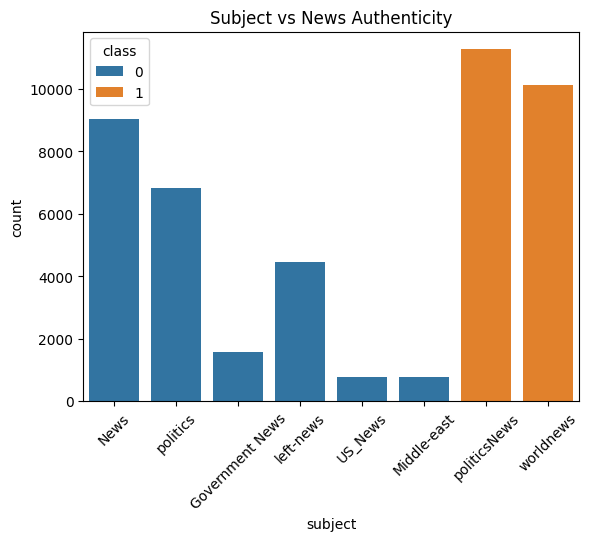

In [17]:
# Visualize Subject vs Class
print("\nVisualizing Subject vs Class:")
sns.countplot(x='subject', hue='class', data=df_merge)
plt.title('Subject vs News Authenticity')
plt.xticks(rotation=45)
plt.show()


Visualizing Text Length vs Class:


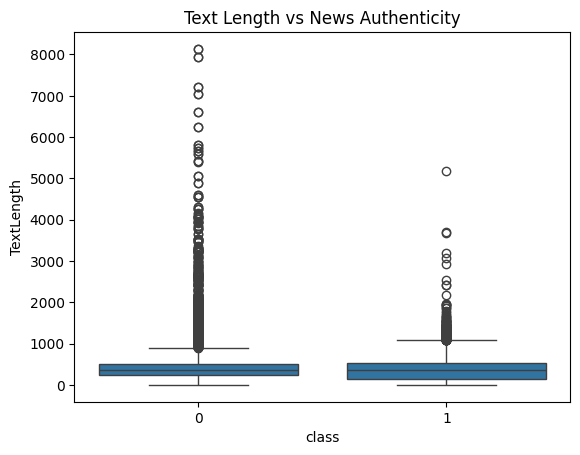

In [18]:
# Visualize TextLength vs Class
print("\nVisualizing Text Length vs Class:")
sns.boxplot(x='class', y='TextLength', data=df_merge)
plt.title('Text Length vs News Authenticity')
plt.show()

In [19]:
# Initialize PorterStemmer
port_stem = PorterStemmer()

In [22]:
# Creating a function to process the texts (updated with stemming)
def wordopt(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W", " ", text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    # Split into words, stem, and remove stopwords
    text = text.split()
    text = [port_stem.stem(word) for word in text if not word in stopwords.words('english')]
    text = ' '.join(text)
    return text

<>:4: SyntaxWarning: invalid escape sequence '\['
<>:6: SyntaxWarning: invalid escape sequence '\S'
<>:10: SyntaxWarning: invalid escape sequence '\w'
<>:4: SyntaxWarning: invalid escape sequence '\['
<>:6: SyntaxWarning: invalid escape sequence '\S'
<>:10: SyntaxWarning: invalid escape sequence '\w'
/tmp/ipython-input-4184210157.py:4: SyntaxWarning: invalid escape sequence '\['
  text = re.sub('\[.*?\]', '', text)
/tmp/ipython-input-4184210157.py:6: SyntaxWarning: invalid escape sequence '\S'
  text = re.sub('https?://\S+|www\.\S+', '', text)
/tmp/ipython-input-4184210157.py:10: SyntaxWarning: invalid escape sequence '\w'
  text = re.sub('\w*\d\w*', '', text)


In [24]:
# Apply text preprocessing to 'content'
df_merge["content"] = df_merge["content"].apply(wordopt)

In [25]:
# Random Shuffling the dataframe
df = df_merge.sample(frac=1).reset_index(drop=True)

In [26]:
# Define features (X) and target (y)
X = df[['content', 'subject', 'TextLength', 'TitleLength']]
y = df['class']

In [27]:
# Identify categorical and numerical columns
categorical_features = ['subject']
numerical_features = ['TextLength', 'TitleLength']
text_feature = 'content'

In [30]:
# Create preprocessing pipelines
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
text_transformer = TfidfVectorizer(max_features=5000, stop_words='english')

In [31]:
# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features),
        ('text', text_transformer, text_feature)
    ])

In [32]:
# Splitting Training and Testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=0)

In [34]:
# Create pipelines for each model
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])
dt_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=0))
])

gbc_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=0))
])

rfc_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=0))
])


Training Logistic Regression...
Logistic Regression Evaluation:
Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00      5868
        True       1.00      1.00      1.00      5352

    accuracy                           1.00     11220
   macro avg       1.00      1.00      1.00     11220
weighted avg       1.00      1.00      1.00     11220


Confusion Matrix for Logistic Regression:


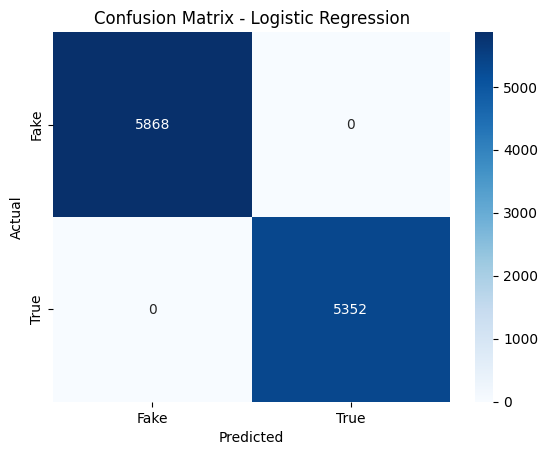

Mean CV Accuracy for Logistic Regression: 1.0000 (+/- 0.0000)

Training Decision Tree...
Decision Tree Evaluation:
Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00      5868
        True       1.00      1.00      1.00      5352

    accuracy                           1.00     11220
   macro avg       1.00      1.00      1.00     11220
weighted avg       1.00      1.00      1.00     11220


Confusion Matrix for Decision Tree:


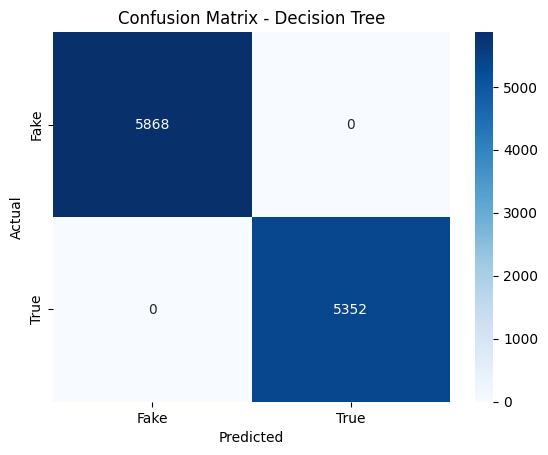

Mean CV Accuracy for Decision Tree: 1.0000 (+/- 0.0000)

Training Gradient Boosting...
Gradient Boosting Evaluation:
Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00      5868
        True       1.00      1.00      1.00      5352

    accuracy                           1.00     11220
   macro avg       1.00      1.00      1.00     11220
weighted avg       1.00      1.00      1.00     11220


Confusion Matrix for Gradient Boosting:


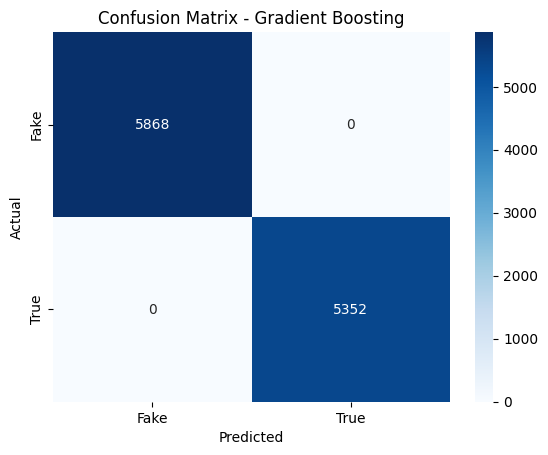

Mean CV Accuracy for Gradient Boosting: 1.0000 (+/- 0.0000)

Training Random Forest...
Random Forest Evaluation:
Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00      5868
        True       1.00      1.00      1.00      5352

    accuracy                           1.00     11220
   macro avg       1.00      1.00      1.00     11220
weighted avg       1.00      1.00      1.00     11220


Confusion Matrix for Random Forest:


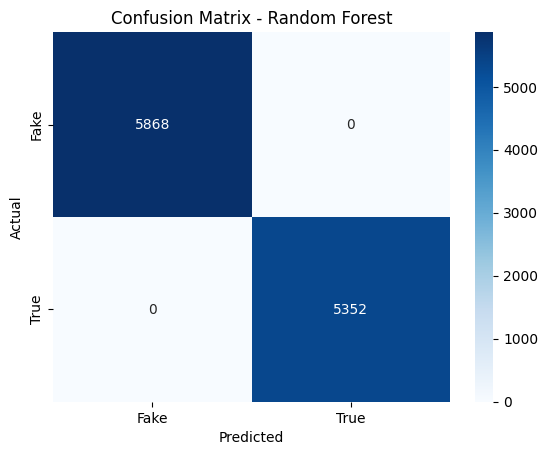

Mean CV Accuracy for Random Forest: 0.9998 (+/- 0.0005)


In [35]:
# Train and evaluate models
models = {
    'Logistic Regression': lr_pipeline,
    'Decision Tree': dt_pipeline,
    'Gradient Boosting': gbc_pipeline,
    'Random Forest': rfc_pipeline
}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"{name} Evaluation:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Fake', 'True']))
    print(f"\nConfusion Matrix for {name}:")
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'True'], yticklabels=['Fake', 'True'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(f'Confusion Matrix - {name}')
    plt.show()
    # Cross-validation
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    print(f"Mean CV Accuracy for {name}: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")


In [36]:
# Save the Random Forest model
model_filename = 'news_classifier_rfc.pkl'
joblib.dump(rfc_pipeline, model_filename)
print(f"\nRandom Forest model saved as '{model_filename}'")


Random Forest model saved as 'news_classifier_rfc.pkl'


In [37]:
# Load the saved model
loaded_rfc_model = joblib.load(model_filename)
print(f"\nModel loaded from '{model_filename}'")


Model loaded from 'news_classifier_rfc.pkl'


In [38]:
# Simple Predictive System (from notebook)
print("\nSimple Predictive System Test:")
sample_index = 3  # Example index from test set
X_new = X_test.iloc[[sample_index]]
prediction = lr_pipeline.predict(X_new)  # Using LR as in notebook
print("Prediction:", prediction)
if prediction[0] == 0:
    print('The news is Real')
else:
    print('The news is Fake')
print("Actual Label:", y_test.iloc[sample_index])


Simple Predictive System Test:
Prediction: [0]
The news is Real
Actual Label: 0


In [39]:
# Model Testing Function
def output_label(n):
    return "Fake News" if n == 0 else "Not A Fake News"

def manual_testing(news, title, subject):
    testing_news = pd.DataFrame({
        "content": [title + ' ' + news],
        "subject": [subject]
    })
    testing_news["content"] = testing_news["content"].apply(wordopt)
    testing_news['TextLength'] = testing_news['content'].apply(lambda x: len(str(x).split()))
    testing_news['TitleLength'] = testing_news['content'].apply(lambda x: len(str(x).split()))  # Approximate since title is part of content

    pred_lr = lr_pipeline.predict(testing_news)
    pred_dt = dt_pipeline.predict(testing_news)
    pred_gbc = gbc_pipeline.predict(testing_news)
    pred_rfc = loaded_rfc_model.predict(testing_news)

    return print(f"\n\nLR Prediction: {output_label(pred_lr[0])}\n"
                 f"DT Prediction: {output_label(pred_dt[0])}\n"
                 f"GBC Prediction: {output_label(pred_gbc[0])}\n"
                 f"RFC Prediction: {output_label(pred_rfc[0])}")

In [40]:
# Test with example news articles
print("\nTesting with sample articles:")
news_samples = [
    {
        'title': 'NATO allies welcome Trump’s new Afghanistan strategy',
        'text': 'BRUSSELS (Reuters) - NATO allies on Tuesday welcomed President Donald Trump s decision to commit more forces to Afghanistan...',
        'subject': 'worldnews'
    },
    {
        'title': 'Astroturfing: Journalist Reveals Brainwashing Tactics',
        'text': 'Vic Bishop Waking TimesOur reality is carefully constructed by powerful corporate, political and special interest sources...',
        'subject': 'Middle-east'
    },
    {
        'title': 'Brazilian builder owner dies of heart attack',
        'text': 'SAO PAULO (Reuters) - Cesar Mata Pires, the owner and co-founder of Brazilian engineering conglomerate OAS SA...',
        'subject': 'worldnews'
    }
]

for sample in news_samples:
    print(f"\nTesting article: {sample['title']}")
    manual_testing(sample['text'], sample['title'], sample['subject'])


Testing with sample articles:

Testing article: NATO allies welcome Trump’s new Afghanistan strategy


LR Prediction: Not A Fake News
DT Prediction: Not A Fake News
GBC Prediction: Not A Fake News
RFC Prediction: Not A Fake News

Testing article: Astroturfing: Journalist Reveals Brainwashing Tactics


LR Prediction: Fake News
DT Prediction: Fake News
GBC Prediction: Fake News
RFC Prediction: Fake News

Testing article: Brazilian builder owner dies of heart attack


LR Prediction: Not A Fake News
DT Prediction: Not A Fake News
GBC Prediction: Not A Fake News
RFC Prediction: Not A Fake News
